### 02. k-Anonymity

In this notebook, we'll explore data anonymization, in particular "k-anonymity" [1]. We will implement a simple algorithm [2] to produce a k-anonymous dataset.

For more reading on the topic, please see: 

- [k-Anonymity: A Model For Protecting Privacy. Latanya Sweeney](https://epic.org/privacy/reidentification/Sweeney_Article.pdf)
- [Mondrian - Multidimensional k-Anonymity](https://www.utdallas.edu/~muratk/courses/privacy08f_files/MultiDim.pdf)

#### Introduction


k-anonymity protects the privacy of individual persons by pooling their attributes into groups of at least $k$ people. The method is based on the assumption that we have a dataset that contains $N$ entries. Each entry consists of a list of $D$ attributes $X_i$ ($i \in [0,D]$) that contain (non-sensitive) information about a person, such as age, gender, zip code of residence, etc. These attributes are called "quasi-identifiers", as combining several of them into a "super-identifier" can often uniquely identify a person even in large datasets (e.g. the combination of gender, age and zip code might be so specific that only a single person in a dataset has a given combination). In addition, the model assumes that the dataset contains a single sensitive attribute that contains e.g. information about a person's income and that we want to protect. The method can also be generalized to datasets with more than one sensitive attribute or datasets where there's no clear distinction between quasi-identifiers and sensitive attributes. For this case study we will look at the simple case though.

Now, k-anonymity demands that we group individual rows/persons of our dataset into group of at least $k$ rows/persons and replace the quasi-identifier attributes of these rows with aggregate quantities, such that it is no longer possible to read the individual values. This protects people by ensuring that an adversary who knows all values of a person's quasi-identifier attributes can only find out which group a person might belong to but not know if the person is really in the dataset.

A large problem of this approach is that it might happen that all people in a k-anonymous group possess the same value of the sensitive attribute. An adversary who knows that a person is in that k-anonymous group can then still learn the value of the sensitive attribute of that person with absolute certainty. This problem can be fixed by using an extension of k-anonymity called "l-diversity": l-diversity ensures that each k-anonymous group contains at least l different values of the sensitive attribute. Therefore, evne if an adversary can identify the group of a person he/she still would not be able to find out the value of that person's sensitive attribute with certainty. 

However, even when using l-diversity an adversary could still learn some information about a person's sensitive attribute using probabilistic reasoning: If, for example, 4 out of 5 people in a 5-anonymous group possess a given value of the sensitive attribute, an attacker can reason that a given person who he/she knows is part of the group will -with high probability- possess that value. Again, this problem can be fixed by extending k-anonymity using a so-called "t-closeness" criterion: t-closeness demands that the statistical distribution of the sensitive attribute values in each k-anonymous group is "close" to the overall distribution of that attribute in the entire dataset. Typically, the closeness can be measured using e.g. the Kullback-Leibler (KL) divergence. An adversary could then only learn a limited amount of information from comparing the distribution of the values in the group to the distribution in the entire dataset.

Of course, k-anonymity, l-diversity and t-closeness all limit the amount of information that a legitimate user can learn from the data as well, so typically we need to balance the degree of privacy against the utility of the resulting data.

#### Implementing k-anonymity

Turning a dataset into a k-anonymous (and possibly l-diverse or t-close) dataset is a complex problem, and finding the optimal partition into k-anonymous groups is an NP-hard problem. Fortunately, several practical algorithms exists that often produce "good enough" results by employing greedy search techniques.

In this tutorial we will explore the so-called "Mondrian" algorithm (see link above), which uses a greedy search algorithm to parition the original data into smaller and smaller groups (if we plot the resulting partition boundaries in 2D they resemble the pictures by Piet Mondrian, hence the name).

The algorithm assumes that we have converted all attributes into numerical or categorical values and that we're able to measure the "span" of a given data attribute $X_i$ (we'll explain that in more detail later).

##### Partitioning

The algorithm proceeds then as follows to partition the data into k-anonymous gorups:

1. Initialize the finished set of partitions to an empty set $P_{finished} = \{\}$.
2. Initialize the working set of paritions to a set containing a partition with the entire dataset $P_{working} = \{\{1, 2,\dots ,N\}\}$.
4. While there are partitions in the working set, pop one partition from it and
  * determine if the partition can be split further without violating the k-anonymity principle (i.e. after the split there are at least $k$ persons in each sub-partition).
  * If no, add the partition to the finished set of partitions.
  * If yes, select the dimension with the largest value range / span of the data points in the partition and split the partition at the median of that dimension.
  * Add the two new partitions to the working set.
5. Return the finished set of partitions

##### Data Aggregation

After obtaining the partitions we still need to aggregate the values of the quasi identifiers and the sensitive attributes in each k-anonymous group. For this, we can e.g. replace numerical attributes with their range (e.g. "age: 24-28") and categorical attributes with their union (e.g. "employment-group: [self-employed, employee, worker]"), though other aggregations are possible. Methods like [Anatomy](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.156.9150&rep=rep1&type=pdf) even preserve the micro-data in each group, which increases re-identification risk though.

##### Usage of the Anonymized Data

We can then use the anonymized data for privacy-preserving machine learning, e.g. using scikit-learn. We'll see an example of that at the end of this notebook.

Let's get started with the anonymization!

In [1]:
# We use Pandas to work with the data as it makes working with categorical data very easy
import pandas as pd

In [597]:
names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv("../data/k-anonymity/adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [598]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


In [599]:
list(df['marital-status'].astype('category').dtype.categories)

['Divorced',
 'Married-AF-spouse',
 'Married-civ-spouse',
 'Married-spouse-absent',
 'Never-married',
 'Separated',
 'Widowed']

In [600]:
def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

full_spans = get_spans(df, df.index)

In [601]:
full_spans

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

In [606]:
def split(df, partition, column):
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        print("Splits:", lv, rv)
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)
    
def diversity(df, partition, column):
    return len(df[column][partition].unique())

In [607]:
column_x = 'age'
column_y = 'fnlwgt'
sensitive_column = 'income'
dfr = df[[column_x, column_y]]
finished_partitions = []
k = 4
l = 2
partitions = [dfr.index]
while partitions:
    partition = partitions.pop(0)
    print(len(partition))
    if len(partition) < 2*k:
        finished_partitions.append(partition)
        continue
    spans = get_spans(dfr, partition, full_spans)
    for column, span in sorted(spans.items(), key=lambda x:-x[1]):
        print(column, span)
        #we try to split this partition along a given column
        lp, rp = split(dfr, partition, column)
        if len(lp) < k or len(rp) < k or diversity(df, lp, sensitive_column) < l or diversity(df, rp, sensitive_column) < l:
            # we cannot split this partition further...
            continue
        # the split is valid, we put the new partitions on the list and continue
        partitions.extend((lp, rp))
        break
    else:
        # no split was possible, we add the partition to the finished partitions
        finished_partitions.append(partition)

48842
age 1.0
23694
fnlwgt 1.0
25148
fnlwgt 0.9755282911004894
11845
age 0.2602739726027397
11849
fnlwgt 0.8833013669437088
12574
age 0.726027397260274
12574
fnlwgt 0.867401386225023
5769
age 0.136986301369863
6076
fnlwgt 0.11559384756937045
5923
age 0.2602739726027397
5926
fnlwgt 0.8409061541219729
6058
age 0.136986301369863
6516
age 0.5753424657534246
6287
age 0.726027397260274
6287
fnlwgt 0.8305165700909605
2861
fnlwgt 0.111864773715171
2908
fnlwgt 0.11668307269732058
3038
age 0.1095890410958904
3038
age 0.1095890410958904
2797
age 0.1232876712328767
3126
age 0.1232876712328767
2963
age 0.2602739726027397
2963
fnlwgt 0.7923064172950007
2920
fnlwgt 0.10812081603934741
3138
fnlwgt 0.10790905984987637
3194
fnlwgt 0.10358936889213627
3322
age 0.4657534246575342
3023
age 0.1232876712328767
3264
age 0.589041095890411
3143
age 0.726027397260274
3144
fnlwgt 0.7852866657871681
1430
age 0.0684931506849315
fnlwgt 0.06821729026496585
1431
age 0.0684931506849315
1454
fnlwgt 0.0749021557862548
14

fnlwgt 0.01380812724314414
160
age 0.0136986301369863
184
fnlwgt 0.022976561363628675
353
fnlwgt 0.022488101399417502
85
fnlwgt 0.011267729506838102
86
fnlwgt 0.01274393399701647
169
fnlwgt 0.02464422592288151
323
fnlwgt 0.024885749755600883
150
age 0.0136986301369863
150
age 0.0136986301369863
fnlwgt 0.007292396058493419
182
age 0.0136986301369863
fnlwgt 0.009880151409058159
182
age 0.0136986301369863
fnlwgt 0.00802711561684984
174
fnlwgt 0.014532022203955714
174
age 0.0136986301369863
173
age 0.0136986301369863
176
age 0.0136986301369863
171
fnlwgt 0.026119753875713324
334
fnlwgt 0.02556972901296584
157
fnlwgt 0.016190215240356805
352
fnlwgt 0.01661913991807133
149
age 0.0136986301369863
fnlwgt 0.010237363128038076
150
fnlwgt 0.014162632812737845
age 0.0136986301369863
181
age 0.0136986301369863
fnlwgt 0.008682680305659574
182
age 0.0136986301369863
182
age 0.0136986301369863
183
fnlwgt 0.014915618879451193
162
fnlwgt 0.016265987423170727
299
fnlwgt 0.01624298515338793
172
fnlwgt 0.0

84
fnlwgt 0.011615469702966279
85
fnlwgt 0.011582319372985187
161
fnlwgt 0.01402461919404106
162
age 0.0136986301369863
fnlwgt 0.010568866427848983
70
fnlwgt 0.010229921217225994
80
fnlwgt 0.010658845894940516
75
age 0.0136986301369863
75
age 0.0136986301369863
fnlwgt 0.003011944266853391
90
age 0.0136986301369863
92
age 0.0136986301369863
fnlwgt 0.005606464990883659
88
age 0.0136986301369863
fnlwgt 0.003229789292443416
94
age 0.0136986301369863
fnlwgt 0.004743879874028746
87
age 0.0136986301369863
87
age 0.0136986301369863
79
fnlwgt 0.011113478991824046
95
fnlwgt 0.010884809368689175
80
fnlwgt 0.00885384425433745
93
fnlwgt 0.009307800813874428
74
fnlwgt 0.007245714981581271
102
fnlwgt 0.007245714981581271
84
fnlwgt 0.015139552741160195
87
fnlwgt 0.010934873132334088
167
age 0.0136986301369863
167
age 0.0136986301369863
75
fnlwgt 0.009815203823789082
82
fnlwgt 0.006331036489041786
176
age 0.0136986301369863
176
age 0.0136986301369863
90
age 0.0136986301369863
fnlwgt 0.00442793693318855

age 0.0136986301369863
63
fnlwgt 0.03873243962749854
194
fnlwgt 0.040235705611539024
80
fnlwgt 0.022634910003619474
178
age 0.0273972602739726
66
fnlwgt 0.01867784306363172
131
fnlwgt 0.019175774550694635
74
fnlwgt 0.01985772419601993
126
fnlwgt 0.020279883500268922
68
fnlwgt 0.021199297754234278
136
fnlwgt 0.020953714697435587
85
fnlwgt 0.017776695318023294
121
fnlwgt 0.01715901672062052
91
fnlwgt 0.03824939196205979
112
fnlwgt 0.03723526247957703
97
fnlwgt 0.024464266988698444
112
age 0.0273972602739726
101
fnlwgt 0.021598454788700473
101
fnlwgt 0.017958007326899464
105
age 0.0273972602739726
106
age 0.0273972602739726
109
age 0.0547945205479452
109
age 0.0547945205479452
101
fnlwgt 0.036798895891050426
118
fnlwgt 0.03685640156550742
110
fnlwgt 0.055182445208931646
110
fnlwgt 0.043992517496947124
113
fnlwgt 0.1011213606519114
113
age 0.136986301369863
41
fnlwgt 0.0025938441866837155
41
fnlwgt 0.004234447252074433
40
fnlwgt 0.0026527029358338152
42
fnlwgt 0.0035842948620371214
41
fnlw

fnlwgt 0.006439959001836799
80
age 0.0136986301369863
81
age 0.0136986301369863
81
age 0.0136986301369863
81
age 0.0136986301369863
fnlwgt 0.004797326324406423
35
fnlwgt 0.00425744952185723
35
fnlwgt 0.005845282674216823
40
fnlwgt 0.004475294547447255
40
fnlwgt 0.005840546912790953
37
fnlwgt 0.00410184593215007
38
fnlwgt 0.00417491196557778
age 0.0
36
age 0.0136986301369863
fnlwgt 0.0018875391968825159
39
age 0.0136986301369863
fnlwgt 0.0010905782026432314
44
fnlwgt 0.0041329666500915015
46
fnlwgt 0.0041708527414984625
45
age 0.0136986301369863
fnlwgt 0.0029720285634067716
47
age 0.0136986301369863
fnlwgt 0.0025992564854561383
43
age 0.0136986301369863
fnlwgt 0.001988343261518894
45
age 0.0136986301369863
fnlwgt 0.0012299448960331233
47
age 0.0136986301369863
fnlwgt 0.0025011585702059717
47
age 0.0136986301369863
42
fnlwgt 0.00569847407001485
45
fnlwgt 0.005995473965151561
40
fnlwgt 0.008411388829691871
47
fnlwgt 0.008429655338048798
38
fnlwgt 0.007307279880117582
41
fnlwgt 0.003722308

fnlwgt 0.004490854906417972
36
age 0.0136986301369863
fnlwgt 0.0037656068709132915
41
age 0.0136986301369863
33
fnlwgt 0.003806199111706464
34
fnlwgt 0.004040281033613758
43
fnlwgt 0.00387588245840141
46
fnlwgt 0.004283834478372792
36
fnlwgt 0.008285552883233037
37
fnlwgt 0.009941039770247916
37
fnlwgt 0.003166194781867446
37
fnlwgt 0.004543624819449096
67
age 0.0136986301369863
fnlwgt 0.008081915141920621
68
age 0.0136986301369863
fnlwgt 0.008633293079361214
69
age 0.0136986301369863
fnlwgt 0.005513779374405916
69
age 0.0136986301369863
34
age 0.0136986301369863
fnlwgt 0.0013172182137384438
35
age 0.0136986301369863
34
age 0.0136986301369863
fnlwgt 0.0022028056003761546
35
age 0.0136986301369863
fnlwgt 0.003465224289043816
34
age 0.0136986301369863
fnlwgt 0.001102755874881183
35
age 0.0136986301369863
32
fnlwgt 0.007598190939135318
38
fnlwgt 0.007611721686066375
34
fnlwgt 0.006236997797870937
34
fnlwgt 0.006425751717559189
32
age 0.0136986301369863
37
age 0.0136986301369863
fnlwgt 0.0

56
fnlwgt 0.06571410208272022
57
age 0.0410958904109589
50
fnlwgt 0.10332416625228755
63
age 0.1095890410958904
20
fnlwgt 0.0012001772527847968
21
fnlwgt 0.0013733708135023324
20
fnlwgt 0.0012671544500935314
21
fnlwgt 0.0026838236537752476
19
fnlwgt 0.0010682524702069866
21
fnlwgt 0.0014789106395645805
21
fnlwgt 0.0010060110343241223
21
fnlwgt 0.002548516184464673
20
fnlwgt 0.0023469080551919166
21
fnlwgt 0.002511306630404265
17
fnlwgt 0.0016108354221423908
24
fnlwgt 0.004471911860714491
20
fnlwgt 0.0032866184295538576
21
fnlwgt 0.0019328671991015584
21
fnlwgt 0.0033441241040108515
21
fnlwgt 0.0026148168444268547
age 0.0
36
fnlwgt 0.00375342919867534
43
fnlwgt 0.0038555863380048236
40
fnlwgt 0.001891598420961833
40
fnlwgt 0.003887383593292809
75
fnlwgt 0.007050872225774043
77
fnlwgt 0.007295778745226183
76
age 0.0136986301369863
fnlwgt 0.003561969129600877
76
age 0.0136986301369863
fnlwgt 0.0030423884474482703
39
fnlwgt 0.004708023394661444
41
fnlwgt 0.0045875997469750325
40
fnlwgt 0.0

33
fnlwgt 0.004357577049147056
33
fnlwgt 0.006378394103300488
41
fnlwgt 0.005134918460336307
42
fnlwgt 0.006124016060996607
39
age 0.0136986301369863
fnlwgt 0.0037980806635478296
39
age 0.0136986301369863
fnlwgt 0.002627671054011359
39
age 0.0136986301369863
fnlwgt 0.001917983377477395
40
age 0.0136986301369863
fnlwgt 0.004019984913217172
36
fnlwgt 0.006864824455472003
41
fnlwgt 0.0066510386539612954
age 0.0
39
age 0.0136986301369863
fnlwgt 0.001860477703020401
41
age 0.0136986301369863
fnlwgt 0.0028028942267685534
19
fnlwgt 0.00236652763824195
20
fnlwgt 0.002773126583520227
36
age 0.0136986301369863
fnlwgt 0.0018259742983462045
38
age 0.0136986301369863
fnlwgt 0.002163566434276088
37
fnlwgt 0.004289246777145215
37
fnlwgt 0.004390727379128146
age 0.0
36
fnlwgt 0.003968568074879154
38
fnlwgt 0.00429736522530385
37
fnlwgt 0.004463116875209304
age 0.0
38
fnlwgt 0.003913092012461818
19
age 0.0136986301369863
fnlwgt 0.0011913822672796094
19
age 0.0136986301369863
fnlwgt 0.001012776407789651

20
fnlwgt 0.001300304780074622
age 0.0
21
fnlwgt 0.0012319745080727818
20
fnlwgt 0.0017231406216701678
21
fnlwgt 0.0016886372169959713
41
fnlwgt 0.005122064250751802
41
fnlwgt 0.004290599851838321
47
fnlwgt 0.004846713550704783
47
fnlwgt 0.004433349231960977
34
fnlwgt 0.0034997276937180125
39
fnlwgt 0.00345439969149897
51
fnlwgt 0.003996982643434374
52
fnlwgt 0.0030031492813482035
19
fnlwgt 0.003555203756135348
27
fnlwgt 0.0033948644050023173
age 0.0
20
fnlwgt 0.0020959126996208007
age 0.0
20
fnlwgt 0.0017035210386201344
age 0.0
34
age 0.0136986301369863
40
age 0.0136986301369863
fnlwgt 0.00127391982355906
37
age 0.0136986301369863
fnlwgt 0.001476204490178369
38
age 0.0136986301369863
fnlwgt 0.0016994618145408172
37
age 0.0136986301369863
fnlwgt 0.001577008554814747
38
age 0.0136986301369863
fnlwgt 0.0023110515758246143
37
age 0.0136986301369863
fnlwgt 0.002350290741924681
38
age 0.0136986301369863
21
fnlwgt 0.0021222976561363627
22
fnlwgt 0.00587978607889102
36
fnlwgt 0.00324737926345

age 0.0136986301369863
fnlwgt 0.006379747177993593
23
fnlwgt 0.00618355134749326
24
fnlwgt 0.01662928797826962
42
age 0.0136986301369863
44
age 0.0136986301369863
10
fnlwgt 0.0036215044160975295
10
fnlwgt 0.0108787205325702
age 0.0
20
fnlwgt 0.016447299432046897
41
fnlwgt 0.016595461110941977
24
fnlwgt 0.014515785307638446
37
fnlwgt 0.01659681418563508
22
fnlwgt 0.01395425930999956
age 0.0
34
age 0.0136986301369863
19
fnlwgt 0.018225239578787848
41
fnlwgt 0.019743389384452494
20
fnlwgt 0.015337778183700185
age 0.0
38
fnlwgt 0.016214570584832708
17
fnlwgt 0.014237728458205215
41
fnlwgt 0.016622522604804093
23
age 0.0273972602739726
23
age 0.0273972602739726
fnlwgt 0.02320658406145665
28
age 0.0273972602739726
29
age 0.0273972602739726
28
fnlwgt 0.03721902558325976
30
fnlwgt 0.034112366087888965
19
fnlwgt 0.04473670857815529
28
fnlwgt 0.04563988593580337
22
fnlwgt 0.04483142380667269
26
fnlwgt 0.04540986323797539
20
age 0.136986301369863
fnlwgt 0.02073586967184556
20
age 0.12328767123287

fnlwgt 0.0020918534755414836
15
fnlwgt 0.003020739252358578
14
fnlwgt 0.0016331611545786356
15
fnlwgt 0.001631131542538977
32
age 0.0136986301369863
fnlwgt 0.002840103780828961
32
age 0.0136986301369863
33
age 0.0136986301369863
fnlwgt 0.0027149443717166795
33
age 0.0136986301369863
30
fnlwgt 0.004891365015577272
30
fnlwgt 0.0032169350828589113
35
fnlwgt 0.004341340152829787
36
fnlwgt 0.003945565805096356
15
fnlwgt 0.002221748646079635
age 0.0
15
fnlwgt 0.0023983248935299352
15
fnlwgt 0.0021595072101967708
16
fnlwgt 0.0017941770430582194
15
fnlwgt 0.0037825203045771132
15
fnlwgt 0.0044705587860213855
age 0.0
15
fnlwgt 0.0025079239436715003
16
fnlwgt 0.003075538777429361
34
fnlwgt 0.00413026050070529
36
fnlwgt 0.0051903945227536425
35
fnlwgt 0.004097786708070752
36
fnlwgt 0.0051903945227536425
35
age 0.0136986301369863
fnlwgt 0.004283834478372792
35
age 0.0136986301369863
36
fnlwgt 0.0057634216552839256
37
fnlwgt 0.0058621961078806455
16
fnlwgt 0.0017515551902253885
17
fnlwgt 0.00261278

fnlwgt 0.006958863146642852
36
fnlwgt 0.015717315635116347
36
age 0.0136986301369863
fnlwgt 0.007374257077426317
24
age 0.0136986301369863
fnlwgt 0.004653900406937214
26
age 0.0136986301369863
fnlwgt 0.0035322014863525503
25
age 0.0136986301369863
fnlwgt 0.006375687953914276
26
age 0.0136986301369863
fnlwgt 0.005948792888239413
25
age 0.0136986301369863
25
age 0.0136986301369863
fnlwgt 0.00369930621095111
25
age 0.0136986301369863
fnlwgt 0.0038021398876271466
26
age 0.0136986301369863
fnlwgt 0.004676902676720012
19
fnlwgt 0.012511881687148835
20
fnlwgt 0.009138666477236209
33
age 0.0136986301369863
33
age 0.0136986301369863
fnlwgt 0.011520077937102323
22
fnlwgt 0.010552629531531714
23
fnlwgt 0.005339232738995274
30
age 0.0136986301369863
fnlwgt 0.009656217547349157
31
age 0.0136986301369863
fnlwgt 0.008056883260098166
17
fnlwgt 0.015899304181339072
18
fnlwgt 0.023889886781475054
37
age 0.0410958904109589
fnlwgt 0.013281781187526005
37
age 0.0410958904109589
24
age 0.0136986301369863
fn

fnlwgt 0.0035105522912628586
19
age 0.0136986301369863
fnlwgt 0.0014301999506127737
19
age 0.0136986301369863
fnlwgt 0.0028976094552859554
19
age 0.0136986301369863
fnlwgt 0.0021135026706311753
19
age 0.0136986301369863
fnlwgt 0.0010601340220483522
19
age 0.0136986301369863
fnlwgt 0.002392912594757512
19
age 0.0136986301369863
fnlwgt 0.0013138355270056795
19
age 0.0136986301369863
fnlwgt 0.0014281703385731152
19
age 0.0136986301369863
fnlwgt 0.001995108634984423
18
fnlwgt 0.005503631314207623
20
fnlwgt 0.007374933614772869
19
age 0.0136986301369863
19
age 0.0136986301369863
fnlwgt 0.0035207003514611517
15
fnlwgt 0.00224407437851588
18
fnlwgt 0.0039056501016497365
17
fnlwgt 0.005226251002120944
17
fnlwgt 0.003469960050469686
15
fnlwgt 0.0025762542156733408
18
fnlwgt 0.004077490587674166
17
fnlwgt 0.007472354992676483
17
fnlwgt 0.00447394147275415
29
fnlwgt 0.00764351894135436
30
fnlwgt 0.006274207351931345
62
age 0.0136986301369863
fnlwgt 0.007489944963686858
62
age 0.0136986301369863
f

age 0.0136986301369863
22
age 0.0136986301369863
fnlwgt 0.011575553999519659
22
age 0.0136986301369863
22
age 0.0136986301369863
fnlwgt 0.0057553032071252916
23
age 0.0136986301369863
23
age 0.0136986301369863
18
age 0.0136986301369863
fnlwgt 0.0040950805586845405
21
age 0.0136986301369863
fnlwgt 0.007857981280211621
19
age 0.0136986301369863
20
age 0.0136986301369863
13
fnlwgt 0.008077179380494752
40
age 0.0136986301369863
16
fnlwgt 0.018815856682328505
38
fnlwgt 0.01848908914394347
16
fnlwgt 0.009396427206272854
20
fnlwgt 0.00856428627001282
20
age 0.0136986301369863
fnlwgt 0.006787022660618423
21
age 0.0136986301369863
fnlwgt 0.01302605007052902
18
fnlwgt 0.010894280891540915
18
fnlwgt 0.019555312002110796
42
fnlwgt 0.029823119310743752
44
fnlwgt 0.030619403767636482
24
age 0.0273972602739726
27
age 0.0273972602739726
27
age 0.0273972602739726
27
age 0.0273972602739726
26
age 0.0273972602739726
26
age 0.0273972602739726
29
age 0.0410958904109589
38
age 0.2465753424657534
14
fnlwgt 0

10
fnlwgt 0.0006907446308304834
age 0.0
10
fnlwgt 0.001982254425399918
age 0.0
11
fnlwgt 0.0011900291925865038
11
fnlwgt 0.0004573392462697422
age 0.0
11
fnlwgt 0.0007435145438616076
age 0.0
11
fnlwgt 0.002221748646079635
12
fnlwgt 0.0022136301979210006
age 0.0
11
fnlwgt 0.002286019694002158
12
fnlwgt 0.0019416621846067457
11
fnlwgt 0.000703598840414988
12
fnlwgt 0.002037053950470701
11
fnlwgt 0.0014417010855041726
age 0.0
12
fnlwgt 0.0014369653240783025
11
fnlwgt 0.0008592024301221488
age 0.0
11
fnlwgt 0.00024964228087801015
10
fnlwgt 0.0004377196632197089
age 0.0
12
fnlwgt 0.0008625851168549131
10
fnlwgt 0.0007895190834272029
11
fnlwgt 0.0009525645839464453
12
fnlwgt 0.00043433697648694454
15
fnlwgt 0.0016121884968354966
21
fnlwgt 0.004717494917513184
23
fnlwgt 0.0040193083758706186
22
age 0.0136986301369863
22
age 0.0136986301369863
fnlwgt 0.0005906171035406582
21
age 0.0136986301369863
fnlwgt 0.0015397990007543392
22
age 0.0136986301369863
fnlwgt 0.0010493094245035061
21
age 0.0136

18
age 0.0136986301369863
fnlwgt 0.0010472798124638476
18
age 0.0136986301369863
fnlwgt 0.0017772636093943976
16
fnlwgt 0.0029997665946154394
age 0.0
17
fnlwgt 0.004059224079317239
age 0.0
20
fnlwgt 0.00441508272360405
age 0.0
21
fnlwgt 0.0026148168444268547
age 0.0
8
fnlwgt 0.0015715962560423243
age 0.0
10
fnlwgt 0.0006528585394235225
age 0.0
10
fnlwgt 0.0003172960155332975
age 0.0
12
fnlwgt 0.00030038258186947564
11
fnlwgt 0.0004417788872990261
age 0.0
11
fnlwgt 0.0010885485906035727
age 0.0
10
fnlwgt 0.0009018242829549798
10
fnlwgt 0.0009464757478274694
age 0.0
10
fnlwgt 0.000634592031066595
age 0.0
11
fnlwgt 0.0010939608893759958
age 0.0
9
age 0.0136986301369863
fnlwgt 0.0003950978103868779
10
age 0.0136986301369863
fnlwgt 0.0006041478504717157
10
fnlwgt 0.0004837242027853043
10
fnlwgt 0.00040389279589206524
age 0.0
8
age 0.0136986301369863
fnlwgt 0.0003382686732764365
9
age 0.0136986301369863
fnlwgt 0.0002854987602453124
9
age 0.0136986301369863
fnlwgt 0.00030241219390913425
13
ag

13
fnlwgt 0.0017765870720478447
10
fnlwgt 0.0011230519952777694
age 0.0
12
fnlwgt 0.003294736877712492
age 0.0
12
fnlwgt 0.0022670766482986776
12
fnlwgt 0.0024632724787990107
15
fnlwgt 0.0051146223399397206
age 0.0
16
fnlwgt 0.0038393494416875547
age 0.0
17
fnlwgt 0.005673442188192394
17
fnlwgt 0.002990295071763699
age 0.0
14
fnlwgt 0.004152586233141535
age 0.0
15
fnlwgt 0.004936016480449762
age 0.0
17
fnlwgt 0.0024125321778075454
19
fnlwgt 0.006164608301789779
age 0.0
8
fnlwgt 0.0031594294084019174
age 0.0
8
fnlwgt 0.003112748331489769
age 0.0
17
age 0.0136986301369863
fnlwgt 0.0038528801886186124
22
age 0.0136986301369863
fnlwgt 0.003978716135077447
19
age 0.0136986301369863
fnlwgt 0.00242538638739205
20
age 0.0136986301369863
6
7
20
fnlwgt 0.005583462721100861
22
fnlwgt 0.00660976987582157
20
age 0.0136986301369863
22
age 0.0136986301369863
fnlwgt 0.0043832854683160645
9
fnlwgt 0.002281283932576288
age 0.0
10
fnlwgt 0.0018740084499514584
9
fnlwgt 0.0013794596496213081
10
fnlwgt 0.00

20
fnlwgt 0.004095757096031094
age 0.0
16
fnlwgt 0.0038955020414514433
16
fnlwgt 0.005712004816945907
20
fnlwgt 0.003716896181961485
21
fnlwgt 0.006869560216897873
9
age 0.0136986301369863
fnlwgt 0.001390960784512707
9
age 0.0136986301369863
fnlwgt 0.0009430930610947051
10
age 0.0136986301369863
fnlwgt 0.0012319745080727818
10
age 0.0136986301369863
fnlwgt 0.0011047854869208418
9
age 0.0136986301369863
fnlwgt 0.0010026283475913578
10
age 0.0136986301369863
fnlwgt 0.0008977650588756626
9
age 0.0136986301369863
fnlwgt 0.00033353291185056645
9
age 0.0136986301369863
fnlwgt 0.0013578104545316162
7
11
fnlwgt 0.001700814889233923
age 0.0
10
fnlwgt 0.0022379855423969044
10
fnlwgt 0.001647368438856246
age 0.0
10
fnlwgt 0.001828003910385863
11
fnlwgt 0.0018564184789410837
age 0.0
8
fnlwgt 0.00039306819834721924
8
fnlwgt 0.00020702042804517917
8
fnlwgt 0.002041789711896571
age 0.0
9
fnlwgt 0.0005852048047682352
8
fnlwgt 0.0009769199284223487
8
fnlwgt 0.0010804301424449383
9
fnlwgt 0.000795607919

age 0.0
8
fnlwgt 0.001765085937156446
8
fnlwgt 0.0018530357922083194
age 0.0
9
fnlwgt 0.003161459020441576
8
fnlwgt 0.0012590360019348967
age 0.0
8
fnlwgt 0.000597382477006187
8
fnlwgt 0.0015966281378647805
9
fnlwgt 0.0010269836920672613
7
9
fnlwgt 0.0008652912662411247
5
12
fnlwgt 0.0006393277924924651
7
8
fnlwgt 0.0008436420711514328
age 0.0
8
fnlwgt 0.0006839792573649547
11
fnlwgt 0.001519502880357753
16
fnlwgt 0.0024747736136904097
16
fnlwgt 0.002877313334889369
16
fnlwgt 0.005048321679977539
age 0.0
16
fnlwgt 0.0023712633996678203
14
fnlwgt 0.0004194531548627813
18
fnlwgt 0.0028001880773823417
16
fnlwgt 0.0024713909269576456
17
fnlwgt 0.0022954912168538983
30
fnlwgt 0.00980979152501666
31
fnlwgt 0.009489112822750598
30
age 0.0136986301369863
31
age 0.0136986301369863
fnlwgt 0.0022779012458435236
31
fnlwgt 0.0029747347127929828
36
fnlwgt 0.003135074063926014
34
age 0.0136986301369863
fnlwgt 0.0023103750384780614
34
age 0.0136986301369863
fnlwgt 0.0027744796582133326
8
fnlwgt 0.0006

fnlwgt 0.00236652763824195
12
fnlwgt 0.0029334659346532577
14
fnlwgt 0.0026729990562304015
17
fnlwgt 0.0021344753283743145
16
fnlwgt 0.0021723614197812755
16
fnlwgt 0.0022677531856452305
13
fnlwgt 0.0015147671189318828
14
fnlwgt 0.001359840066571275
age 0.0
14
fnlwgt 0.0006690954357407915
14
fnlwgt 0.0024355344475903433
14
fnlwgt 0.0009640657188378441
14
fnlwgt 0.001918659914823948
15
fnlwgt 0.0020384070251638067
15
fnlwgt 0.0012759494355987187
13
age 0.0136986301369863
13
age 0.0136986301369863
fnlwgt 0.0013097763029263623
13
age 0.0136986301369863
fnlwgt 0.00078884254608065
13
age 0.0136986301369863
fnlwgt 0.0009227969406981189
13
age 0.0136986301369863
fnlwgt 0.000655564688809734
13
age 0.0136986301369863
fnlwgt 0.0015749789427750886
12
fnlwgt 0.0032379077406020505
16
fnlwgt 0.003927975834085981
13
age 0.0136986301369863
13
age 0.0136986301369863
fnlwgt 0.0011582319372985188
13
age 0.0136986301369863
fnlwgt 0.0005791159686492594
14
age 0.0136986301369863
fnlwgt 0.0009633891814912912

10
fnlwgt 0.003049830358260352
16
fnlwgt 0.006993366551317049
17
fnlwgt 0.009584504588614554
16
age 0.0136986301369863
fnlwgt 0.00746220693247819
17
age 0.0136986301369863
fnlwgt 0.003976686523037788
11
fnlwgt 0.0035775294885715928
11
fnlwgt 0.006130781434462136
age 0.0
11
fnlwgt 0.0028387507061358556
12
fnlwgt 0.002223101720772741
age 0.0
15
age 0.0136986301369863
fnlwgt 0.0030883929870138657
15
age 0.0136986301369863
fnlwgt 0.006225496662979538
15
age 0.0136986301369863
16
age 0.0136986301369863
fnlwgt 0.0022305436315848224
7
10
fnlwgt 0.00604689080348958
age 0.0
9
fnlwgt 0.012871799555514964
age 0.0
9
fnlwgt 0.007458147708398873
18
age 0.0410958904109589
19
age 0.0410958904109589
fnlwgt 0.009444461357878109
14
fnlwgt 0.021051812612685752
23
fnlwgt 0.028932119625333617
12
age 0.0136986301369863
fnlwgt 0.006829644513451254
12
age 0.0136986301369863
fnlwgt 0.0038731763090151983
14
age 0.0136986301369863
fnlwgt 0.003294736877712492
15
age 0.0136986301369863
fnlwgt 0.004878510805992768
1

fnlwgt 0.0016176007956079195
37
age 0.0136986301369863
19
fnlwgt 0.0015438582248336564
19
fnlwgt 0.0019146006907446308
17
fnlwgt 0.0028685183493841818
21
fnlwgt 0.0031837847528778207
18
fnlwgt 0.002158154135503665
19
fnlwgt 0.0027927461665702602
20
fnlwgt 0.003988187657929187
20
fnlwgt 0.0034043359278540576
31
age 0.0136986301369863
33
age 0.0136986301369863
fnlwgt 0.002050584697401758
32
age 0.0136986301369863
32
age 0.0136986301369863
fnlwgt 0.00279748192799613
32
fnlwgt 0.005977883994141187
32
fnlwgt 0.0061849044221863655
25
fnlwgt 0.0077050838398906715
39
fnlwgt 0.00750685839735068
8
fnlwgt 0.0006170020600562203
age 0.0
9
fnlwgt 0.0008889700733704753
9
fnlwgt 0.0006548881514631811
9
fnlwgt 0.0009417399864015993
9
fnlwgt 0.0013246601245505256
age 0.0
9
fnlwgt 0.0008159040399427649
9
fnlwgt 0.0009660953308775027
age 0.0
9
fnlwgt 0.0009870679886206418
age 0.0
8
fnlwgt 0.0002868518349384182
9
fnlwgt 0.0004986080244094675
8
fnlwgt 0.0006961569296029064
10
fnlwgt 0.0005446125639750628
7


fnlwgt 0.007946607672610047
11
fnlwgt 0.003822436008023733
15
fnlwgt 0.005481305581771378
15
fnlwgt 0.006788375735311529
26
age 0.0136986301369863
fnlwgt 0.0066280363841784975
27
age 0.0136986301369863
fnlwgt 0.005743125534887339
15
fnlwgt 0.00908454348951198
16
fnlwgt 0.010075670702211938
26
age 0.0136986301369863
26
age 0.0136986301369863
fnlwgt 0.010505948454619565
8
fnlwgt 0.005607818065576765
age 0.0
8
fnlwgt 0.006628712921525051
8
fnlwgt 0.004933986868410104
9
fnlwgt 0.008765217861939024
14
fnlwgt 0.009826028421333928
age 0.0
24
age 0.0136986301369863
15
fnlwgt 0.021497650724064093
23
fnlwgt 0.02159304248992805
12
fnlwgt 0.01038687788162626
16
age 0.0136986301369863
14
age 0.0273972602739726
fnlwgt 0.009142725701315527
15
age 0.0273972602739726
fnlwgt 0.012290653974826045
20
age 0.0273972602739726
20
age 0.0273972602739726
fnlwgt 0.02282231084861462
21
age 0.0410958904109589
22
age 0.0958904109589041
fnlwgt 0.03541808316673601
5
5
5
5
5
5
5
6
11
fnlwgt 0.002399001430876488
12
fnl

11
fnlwgt 0.0042283584159554565
12
fnlwgt 0.00548874749258346
12
fnlwgt 0.0038285248441427087
12
fnlwgt 0.0051112396532069565
20
age 0.0136986301369863
fnlwgt 0.004541595207409437
23
age 0.0136986301369863
fnlwgt 0.0067795807498063415
21
age 0.0136986301369863
fnlwgt 0.0035788825632646986
22
age 0.0136986301369863
fnlwgt 0.0037595180347943158
8
fnlwgt 0.00427842217960037
age 0.0
12
fnlwgt 0.00459639473248022
10
age 0.0136986301369863
fnlwgt 0.0020120220686482447
11
age 0.0136986301369863
fnlwgt 0.0015384459260612334
10
age 0.0136986301369863
fnlwgt 0.0033075910872969964
10
age 0.0136986301369863
fnlwgt 0.0025194250785628993
10
age 0.0136986301369863
fnlwgt 0.0018462704187427906
11
age 0.0136986301369863
fnlwgt 0.002755536612509852
7
8
fnlwgt 0.005398091488145375
age 0.0
13
fnlwgt 0.0075501567875300634
13
fnlwgt 0.0030680968666172794
10
fnlwgt 0.0022427213038227743
11
fnlwgt 0.003145222124124307
10
fnlwgt 0.0022785777831900765
11
fnlwgt 0.0028834021710083453
10
fnlwgt 0.0044184654103368

age 0.0136986301369863
fnlwgt 0.0006650362116614742
5
5
9
fnlwgt 0.0006014417010855042
age 0.0
9
fnlwgt 0.0005960294023130812
age 0.0
9
fnlwgt 0.0011379358169019325
age 0.0
9
fnlwgt 0.00127391982355906
age 0.0
9
fnlwgt 0.0009430930610947051
age 0.0
10
fnlwgt 0.0009451226731343637
age 0.0
9
fnlwgt 0.0010019518102448051
age 0.0
10
fnlwgt 0.0006643596743149214
age 0.0
4
5
4
5
4
5
4
6
5
6
5
6
5
6
5
6
4
5
5
5
7
11
fnlwgt 0.001023601005334497
age 0.0
8
age 0.0136986301369863
fnlwgt 0.0022359559303572456
9
age 0.0136986301369863
fnlwgt 0.0017542613396116
10
age 0.0136986301369863
fnlwgt 0.0011183162338518993
10
age 0.0136986301369863
fnlwgt 0.0010621636340880107
4
5
4
4
5
7
5
6
4
6
5
5
5
5
5
6
4
6
4
7
5
6
5
6
6
7
5
7
6
6
5
6
4
5
5
5
5
6
5
8
fnlwgt 0.0002137858015107079
age 0.0
8
fnlwgt 0.00020499081600552053
age 0.0
8
fnlwgt 0.0006433870165717823
age 0.0
4
8
fnlwgt 0.0011771749830019993
age 0.0
5
7
6
7
4
6
5
6
5
5
4
7
4
4
5
6
5
5
4
5
4
4
5
6
6
6
4
5
6
6
6
6
4
5
4
6
5
5
5
6
5
6
11
fnlwgt 0.001

fnlwgt 0.0008016967556651547
10
age 0.0136986301369863
fnlwgt 0.0001583097390933723
11
age 0.0136986301369863
fnlwgt 0.0005249929809250295
10
age 0.0136986301369863
fnlwgt 0.00030511834329534577
11
age 0.0136986301369863
fnlwgt 0.0005398768025491927
10
fnlwgt 0.001406521143483423
age 0.0
11
fnlwgt 0.0014301999506127737
age 0.0
10
age 0.0136986301369863
fnlwgt 0.0006406808671855708
10
age 0.0136986301369863
10
age 0.0136986301369863
fnlwgt 0.0005324348917371112
11
age 0.0136986301369863
fnlwgt 0.0007753117991495925
10
fnlwgt 0.0012718902115194013
age 0.0
11
fnlwgt 0.0018097374020289356
10
fnlwgt 0.0018246212236530987
age 0.0
11
fnlwgt 0.0012218264478744889
4
6
4
6
5
5
4
6
4
5
5
6
5
5
5
6
4
7
4
7
9
fnlwgt 0.0005344645037767698
9
fnlwgt 0.0005344645037767698
age 0.0
8
age 0.0136986301369863
fnlwgt 0.0008463482205376443
11
age 0.0136986301369863
fnlwgt 0.0005906171035406582
10
age 0.0136986301369863
fnlwgt 0.00033488598654367216
11
age 0.0136986301369863
fnlwgt 0.0009214438660050131
10
fnl

fnlwgt 0.0010953139640691016
11
fnlwgt 0.0014721452660990519
age 0.0
9
fnlwgt 0.003176342842065739
age 0.0
10
fnlwgt 0.0010283367667603671
9
fnlwgt 0.001267830987440084
age 0.0
10
fnlwgt 0.0010411909763448717
9
fnlwgt 0.0004167470054765698
age 0.0
9
fnlwgt 0.0010621636340880107
10
fnlwgt 0.00044110234995247327
11
fnlwgt 0.0014044915314437645
7
12
fnlwgt 0.0016730768580252551
10
fnlwgt 0.0013679585147299094
11
fnlwgt 0.0013036874668073864
10
fnlwgt 0.0006988630789891179
age 0.0
10
fnlwgt 0.0008876169986773695
age 0.0
10
fnlwgt 0.0004600453956559537
11
fnlwgt 0.001188676117893398
4
4
4
4
4
5
4
4
5
5
4
5
4
4
4
5
5
5
4
4
4
4
5
7
4
5
4
5
4
6
4
4
4
5
4
4
4
5
4
4
4
5
4
4
4
4
4
6
4
4
4
5
7
7
7
7
9
fnlwgt 0.004226328803915798
9
fnlwgt 0.001241446030924522
age 0.0
9
fnlwgt 0.001321277437817761
9
fnlwgt 0.0010905782026432314
7
7
9
fnlwgt 0.0012705371368262957
10
fnlwgt 0.002339466144379835
8
fnlwgt 0.002363144951509186
age 0.0
12
fnlwgt 0.0019112180040118665
7
8
fnlwgt 0.0021101199838984112
7
10


fnlwgt 0.0011162866218122406
age 0.0
11
fnlwgt 0.0023225527107160132
11
fnlwgt 0.003272411145276247
age 0.0
11
fnlwgt 0.0020174343674206675
7
7
7
7
5
9
fnlwgt 0.0002888814469780768
7
8
age 0.0136986301369863
fnlwgt 0.00019213660642101595
4
9
fnlwgt 0.0009072365817274029
age 0.0
7
8
age 0.0136986301369863
fnlwgt 0.000570320983144072
6
7
8
fnlwgt 0.001114257009772582
age 0.0
8
fnlwgt 0.0024700378522645398
age 0.0
5
5
5
5
4
5
6
6
9
fnlwgt 0.0010357786775724487
10
fnlwgt 0.0015107078948525656
age 0.0
10
fnlwgt 0.0007293072595839972
10
fnlwgt 0.0007482503052874776
8
fnlwgt 0.0012779790476383772
age 0.0
11
fnlwgt 0.0015864800776664873
age 0.0
10
fnlwgt 0.0008964119841825568
age 0.0
10
fnlwgt 0.0008010202183186017
6
6
6
6
6
6
7
7
8
fnlwgt 0.001332102035362607
9
fnlwgt 0.0005730271325302836
8
fnlwgt 0.0007002161536822237
age 0.0
8
fnlwgt 0.0006325624190269363
8
fnlwgt 0.0007266011101977857
8
fnlwgt 0.0013036874668073864
age 0.0
6
7
7
7
7
7
6
8
fnlwgt 0.0007123938259201753
6
8
fnlwgt 0.00089370

9
fnlwgt 0.0011176396965053464
10
fnlwgt 0.0005290522050043467
10
fnlwgt 0.000997892586165488
10
fnlwgt 0.0010750178436725153
9
age 0.0136986301369863
fnlwgt 0.0003666832418316572
10
age 0.0136986301369863
fnlwgt 0.00028211607351254805
9
age 0.0136986301369863
fnlwgt 0.0007022457657218823
10
age 0.0136986301369863
fnlwgt 0.0006332389563734892
6
9
age 0.0136986301369863
fnlwgt 0.00023340538456074122
11
age 0.0136986301369863
fnlwgt 0.00024828920618490444
12
age 0.0136986301369863
fnlwgt 0.0006203847467889846
9
fnlwgt 0.0007313368716236558
10
fnlwgt 0.0006839792573649547
9
age 0.0136986301369863
fnlwgt 0.0003064714179884515
10
age 0.0136986301369863
fnlwgt 0.0002469361314917987
9
age 0.0136986301369863
fnlwgt 0.0003240613889988262
10
age 0.0136986301369863
fnlwgt 0.0002537015049573274
8
fnlwgt 0.0007786944858823569
11
fnlwgt 0.0006792434959390846
age 0.0
4
5
5
5
5
5
5
5
5
5
4
7
5
5
5
5
4
6
5
6
7
7
8
fnlwgt 0.001438994936117961
9
fnlwgt 0.0010675759328604337
8
fnlwgt 0.0001643985752123481

fnlwgt 0.001364575827997145
10
fnlwgt 0.0015736258680819828
10
fnlwgt 0.002302256590319427
age 0.0
10
fnlwgt 0.0048460370133582295
4
5
5
5
5
5
4
5
5
5
5
5
5
5
9
age 0.0136986301369863
fnlwgt 0.0006271501202545133
10
age 0.0136986301369863
fnlwgt 0.0016811953061838896
9
fnlwgt 0.003996982643434374
age 0.0
11
fnlwgt 0.0035897071608095446
10
age 0.0136986301369863
fnlwgt 0.001267830987440084
10
age 0.0136986301369863
9
fnlwgt 0.003348183328090169
11
fnlwgt 0.0029977369825757807
9
fnlwgt 0.0009579768827188683
11
fnlwgt 0.003810258335785781
10
fnlwgt 0.0021344753283743145
10
fnlwgt 0.002798158465342683
10
fnlwgt 0.003114101406182875
10
fnlwgt 0.002980823548911959
age 0.0
4
4
4
5
5
5
4
6
8
fnlwgt 0.0017238171590167207
age 0.0
9
fnlwgt 0.00187671459933767
age 0.0
8
fnlwgt 0.0012400929562314165
9
fnlwgt 0.0029124932769101185
7
10
fnlwgt 0.0026080514709613256
7
10
fnlwgt 0.0013422500955609002
6
9
fnlwgt 0.001194088416665821
age 0.0
9
fnlwgt 0.0011169631591587935
10
fnlwgt 0.0010526921112362704


8
fnlwgt 0.030579488064189864
6
7
5
9
age 0.1232876712328767
5
5
4
6
5
8
fnlwgt 0.022227634520994646
6
7
6
6
6
6
8
fnlwgt 0.051159754146328264
8
age 0.2054794520547945
fnlwgt 0.04089938874850739
5
8
fnlwgt 0.05629061338258525
5
7
7
8
age 0.136986301369863
fnlwgt 0.05164212527442046
6
6
6
7
5
6
7
7
5
6
5
5
5
6
6
6
6
6
6
6
6
6
4
7
5
6
6
7
5
6
4
8
fnlwgt 0.0001183940356467528
age 0.0
5
5
7
7
7
8
fnlwgt 0.002874607185503158
5
6
6
6
6
7
4
5
6
6
5
6
4
4
6
7
4
5
6
7
5
5
4
7
6
7
4
5
5
5
5
6
5
5
4
7
6
6
6
7
6
6
6
7
5
6
4
5
4
7
5
6
5
6
5
5
5
5
5
6
4
5
5
6
4
6
5
5
4
5
4
4
4
5
7
7
6
7
4
7
6
7
6
7
5
5
5
5
5
5
5
6
5
5
4
6
5
6
5
6
5
6
5
7
5
5
6
6
5
7
6
6
6
6
6
6
4
5
4
5
5
5
5
5
6
6
6
7
6
7
5
7
5
8
fnlwgt 0.0004147173934369112
7
7
4
4
5
5
4
4
4
5
4
5
4
5
4
5
4
4
5
5
4
5
4
4
5
5
5
5
4
5
4
5
5
5
5
5
5
5
4
4
4
5
5
6
5
7
4
5
4
7
4
6
4
5
4
7
4
5
6
6
4
5
5
7
4
5
6
6
6
6
4
6
5
6
5
5
5
6
5
6
5
6
4
5
5
5
5
6
5
6
5
5
5
5
5
5
5
5
5
6
4
5
4
6
5
5
5
5
5
5
6
7
5
5
6
6
4
5
5
5
4
5
4
6
5
5
5
5
5
5
5
5
4
5
4
5
5
6
5
5

In [608]:
len(finished_partitions)

5800

In [609]:
len(finished_partitions[10])

195

In [610]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [611]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        return indexes[column][sv[sv.index[0]]]+offset, indexes[column][sv[sv.index[-1]]]+1.0-offset
    sv = df[column][partition].sort_values()
    next_value = sv[sv.index[-1]]
    larger_values = df[df[column] > next_value][column]
    if len(larger_values) > 0:
        next_value = larger_values.min()
    return sv[sv.index[0]]+offset, next_value-offset

def get_partition_rects(df, column_x, column_y, indexes, offset=0.1):
    rects = []
    for partition in finished_partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offset)
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offset)
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [612]:
indexes = build_indexes(df)
rects = get_partition_rects(df, column_x, column_y, indexes, offset=0.05)

In [613]:
rects[:10]

[((17.05, 19410.05), (22.95, 73521.95)),
 ((17.05, 120251.05), (19.95, 184761.95)),
 ((17.05, 184920.05), (19.95, 247318.95)),
 ((17.05, 73679.05), (22.95, 104044.95)),
 ((17.05, 104112.05), (22.95, 120250.95)),
 ((20.05, 154422.05), (22.95, 184758.95)),
 ((23.05, 123160.05), (24.95, 157844.95)),
 ((20.05, 184779.05), (21.95, 210793.95)),
 ((17.05, 319758.05), (21.95, 377413.95)),
 ((20.05, 120320.05), (22.95, 137874.95))]

Text(0,0.5,'fnlwgt')

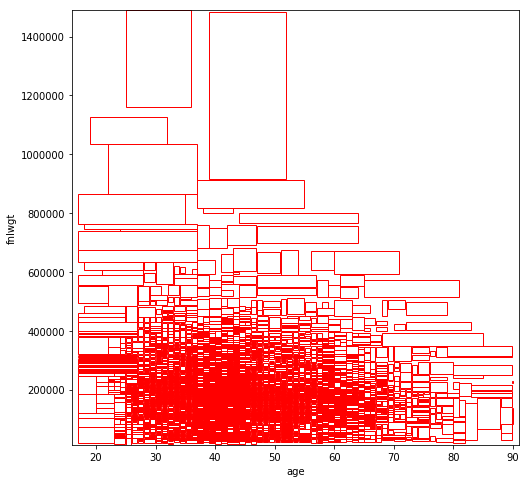

In [616]:
pl.figure(figsize=(8,8))
pl.clf()
ax = pl.subplot(111)
pl.xlim(-10,100)
pl.ylim(-10,100)
for (xl, yl),(xr, yr) in rects:
    ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor='r',facecolor='none'))
pl.xlim(*get_bounds(df, column_x, indexes))
pl.ylim(*get_bounds(df, column_y, indexes))
pl.xlabel(column_x)
pl.ylabel(column_y)